# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=967acfca0b8e5969cc550d556308d6c109adf5275b59db391884025d87ff1e4c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b83c99acd6ebeeac06c6f98a345f9

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 33.08 MiB/s, done.
Resolving deltas: 100% (3/3), done.


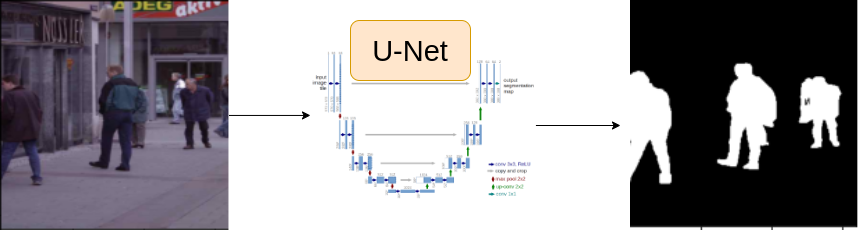

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv" # resimlerin bulunduğu dosya
DATA_DIR = "/content/"

DEVICE = "cuda" # because we are going to use gpu

EPOCHS = 25
LR = 0.003 # learning rate: ağırlıkların hesaplanma hızını belirler
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = " imagenet "



In [6]:
df = pd.read_csv(CSV_FILE) # veriler okunur
df.head() # veriden ilk 5 özet

# kolonlarda, mask:target(ground truth), images:original images (training)
# df.head(10)

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4] # 4.satırda

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) # opencv read BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

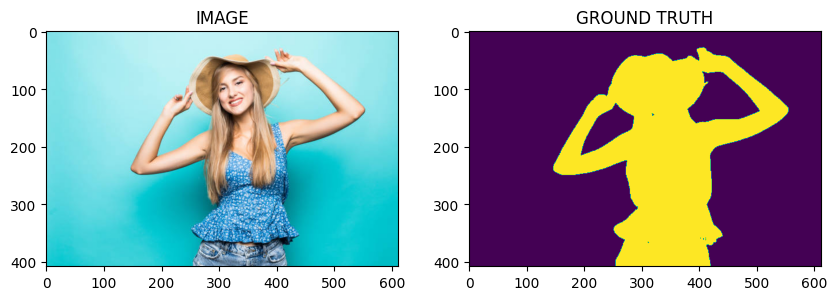

In [8]:
 # Visilation

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH') # TARGET
ax2.imshow(mask)

In [9]:
row = df.iloc[0] # 3.satırda

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) # opencv read BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

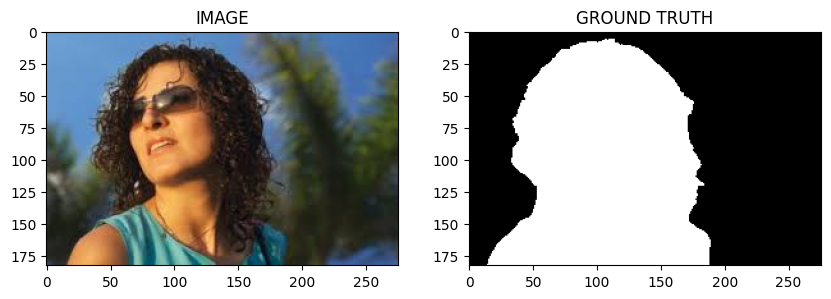

In [10]:
# Visualization

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH') # TARGET
ax2.imshow(mask,cmap = 'gray')

In [11]:
# Split the dataset

train_df, valid_df = train_test_split(df, test_size= 0.2, random_state= 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

ÖNEMLİ !
- Sınıflandırma problemlerinde veri çoklanırken resmi belirli açıyla döndürmek veride label'ı değiştirmez.
- Farklı olarak, segmentasyon işleminde görüntüyü belirli bir açıyla döndürdüğümüzde ground truth yani mask de değişir.

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip( p = 0.5),
      A.VerticalFlip( p = 0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ], is_check_shapes=False)



# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):

    return len(self.df)

  def __getitem__(self, idx): # yukarıda manuel yapmıştık

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path) # opencv read BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread( mask_path, cv2.IMREAD_GRAYSCALE) # (H, W, C)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) # dictionary form
      image = data["image"]
      mask = data["mask"]


    # (h, w, c) => (c, h, w) : pytorch


    image = np.transpose(image, (2,0,1)).astype(np.float32) # transpozunu alıyoruz
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0 )

    return image,mask



In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


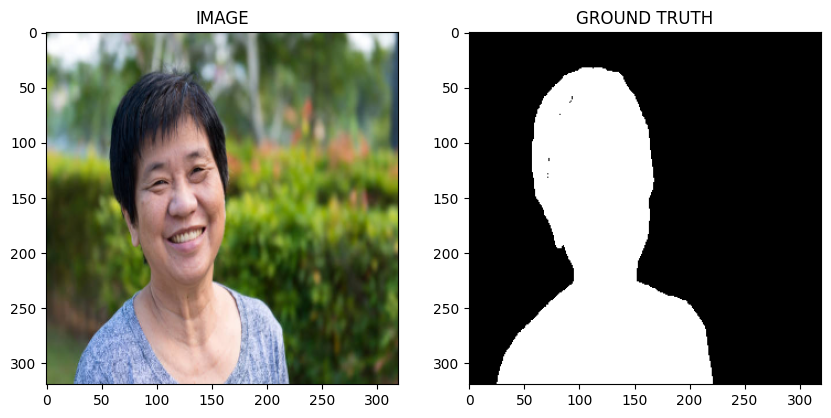

In [18]:
index = 3

image, mask = trainset[index]
helper.show_image(image,mask) # görselleştirme kısa



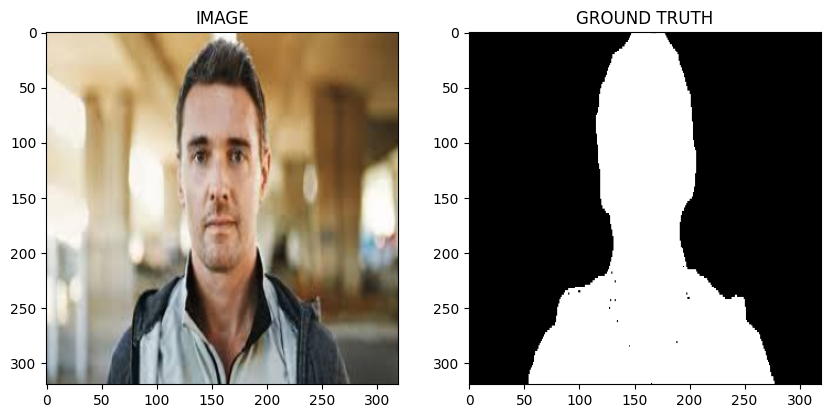

In [19]:
index = 32

image, mask = trainset[index]
helper.show_image(image,mask) # görselleştirme kısa



# Task 5 : Load dataset into batches

In [20]:
from torch.utils.data import DataLoader

In [21]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True )
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [22]:
print(f" total no of batches in trainloader : {len(trainloader)} ")
print(f" total no of batches in validloader : {len(validloader)} ")

 total no of batches in trainloader : 15 
 total no of batches in validloader : 4 


In [23]:
for image, mask in trainloader:
  break

print(f" One batch image shape : {image.shape}")
print(f" One batch mask shape : {mask.shape}")

 One batch image shape : torch.Size([16, 3, 320, 320])
 One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [24]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [25]:

class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= 'imagenet',
        in_channels = 3,
        classes = 1,
        activation = None

    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:

      loss1 = DiceLoss(mode="binary")(logits,masks)
      loss2 = nn.BCEWithLogitsLoss() (logits,masks)
      return logits, loss1 + loss2

    return logits


In [26]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 158MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [27]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in data_loader:

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      optimizer.zero_grad()
      logits, loss = model(images, masks)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  return total_loss / len(data_loader)



In [28]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss =0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss  += loss.item()

    return total_loss / len(data_loader)


# Task 8 : Train Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [30]:
# AYNI HATA YUKARIDA DA ALINDI

In [31]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED MODEL")
    best_valid_loss = valid_loss

    print(f"Epoch : {i+1} train_loss: {train_loss} Valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


SAVED MODEL
Epoch : 1 train_loss: 0.7220239957173665 Valid_loss: 4.77554988861084


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
Epoch : 2 train_loss: 0.3463871161142985 Valid_loss: 0.456666998565197


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED MODEL
Epoch : 4 train_loss: 0.25113772849241894 Valid_loss: 0.26539499312639236


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


SAVED MODEL
Epoch : 7 train_loss: 0.2863921016454697 Valid_loss: 0.21612706780433655


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


SAVED MODEL
Epoch : 8 train_loss: 0.2346295863389969 Valid_loss: 0.18943394348025322


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


SAVED MODEL
Epoch : 12 train_loss: 0.14743851522604626 Valid_loss: 0.1845988668501377


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


SAVED MODEL
Epoch : 13 train_loss: 0.12168438980976741 Valid_loss: 0.1785329133272171


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


SAVED MODEL
Epoch : 21 train_loss: 0.09167634695768356 Valid_loss: 0.17258962616324425


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


SAVED MODEL
Epoch : 24 train_loss: 0.08683001498381297 Valid_loss: 0.16456306725740433


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


In [32]:
!pwd

/content


In [33]:
!ls

best_model.pt  Human-Segmentation-Dataset-master  sample_data


# Task 9 : Inference

In [34]:
idx = 2

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

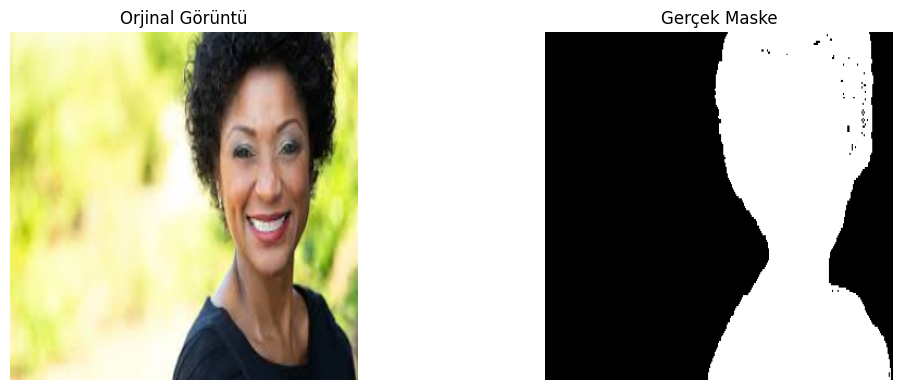

In [36]:
import matplotlib.pyplot as plt

# Görselleri CPU'ya taşıma ve boyutları düzenleme
imagee = image.cpu().squeeze(0)
maskk = mask.cpu().squeeze(0)
pred_maskk = pred_mask.cpu().squeeze(0)

# Görselleri çizdirme
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(imagee.permute(1, 2, 0))
axes[0].set_title('Orjinal Görüntü')
axes[0].axis('off')
axes[1].imshow(maskk, cmap='gray')
axes[1].set_title('Gerçek Maske')
axes[1].axis('off')
# axes[2].imshow(pred_maskk, cmap='gray')
# axes[2].set_title('Tahmin Edilen Maske')
# axes[2].axis('off')

plt.tight_layout()
plt.show()

#helper.show_image(image,pred_masks) # görselleştirme kısa